In [7]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn import metrics
from termcolor import colored

# Improve quality of figures
%config InlineBackend.figure_format = 'retina'

In [2]:
# Data
df = pd.read_csv('home_df.csv')

# Transform NaN values by -1
df = df.fillna(-1)
# Type Int for Prev_Claim1
df['Prev_Claim2'] = df['Prev_Claim2'].astype(int)

df.head()

,NClaims2,Prev_Claim2,year,gender,Age_client,num_policiesC,metro_code,Policy_PaymentMethodH,Insuredcapital_content_re,Insuredcapital_continent_re,appartment,Client_Seniority,Retention
0,0,9,1,1,84,1,0,1,10.045045,11.549088,0,16.963723,1
1,0,9,1,1,83,1,0,1,8.511197,11.506740,0,16.796715,1
2,0,9,1,1,85,1,0,1,10.371130,11.575080,1,18.603696,1
3,0,9,1,1,85,1,0,1,12.156664,12.156664,1,20.484600,1
4,0,9,1,1,82,1,0,1,10.395483,12.369568,1,7.901437,1


### Recall: Variables
- "year": the year of observation, ranging from 1 to 5 (2010 to 2014).
- "gender": a binary variable with 1 = male and 0 = female.
- "Age_client": the age of the customer in years.
- "num_policiesC": the total number of policies held by the customer in the insurance company.
- "metro_code": a binary variable with 1 indicating urban or metropolitan and 0 indicating rural.
- "Policy_PaymentMethodH": a binary variable with 1 indicating annual payment and 0 indicating monthly payment in the homeowners policy.
- "Insuredcapital_content_re": the value of content in the homeowners insurance.
- "Insuredcapital_continent_re": the value of building in the homeowners insurance.
- "appartment": a binary variable with 1 indicating that the homeowners insurance corresponds to an apartment and 0 otherwise.
- "Client_Seniority": the number of years that the customer has been in the company.
- "Retention": a binary variable with 1 indicating that the policy is renewed and 0 indicating that it is not renewed.
- "NClaims2": the number of claims in the homeowners insurance policy for the corresponding year.
- "Prev_Claim2": 1 indicating that the customer had a claim in the homeowners insurance policy in the previous year, 0 if no and -1 if first year.
    
$\textbf{WARNING}$: All monetary units are expressed in Euros. Only claims at fault are considered in the motor insurance policy.

### Goal: predict the variable "NClaims2" (Home)
#### Models: Linear Regression GLM, Logistic Regression
1. GLM
2. Logistic Regression

##### POUR CHOISIR LES PARAMETRES DES MODELES OPTIMAUX POUR CHAQUE MODEL, ON UTILISE GRIDSEARCHCV

In [3]:
# Train/Test Split
# The target variable is "NClaims1"
from sklearn.model_selection import train_test_split

X = df.drop('NClaims2', axis=1)
y = df['NClaims2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Selected Features:
Index(['year', 'Policy_PaymentMethodH', 'Insuredcapital_continent_re',
       'appartment', 'Retention'],
      dtype='object')
Min: 0.011419860545366438
Max: 0.06674828269802313
Count: 9258
[[34509  1175]
 [ 1130    67]]
TN/FP ratio: 0.05702127659574468
True Negatives: 0.18166535614544074
False Positives: 3.1859222906103413
False Negatives: 3.0639082454380304
True Positives: 93.56850410780618
Metric: 87.50033892790326


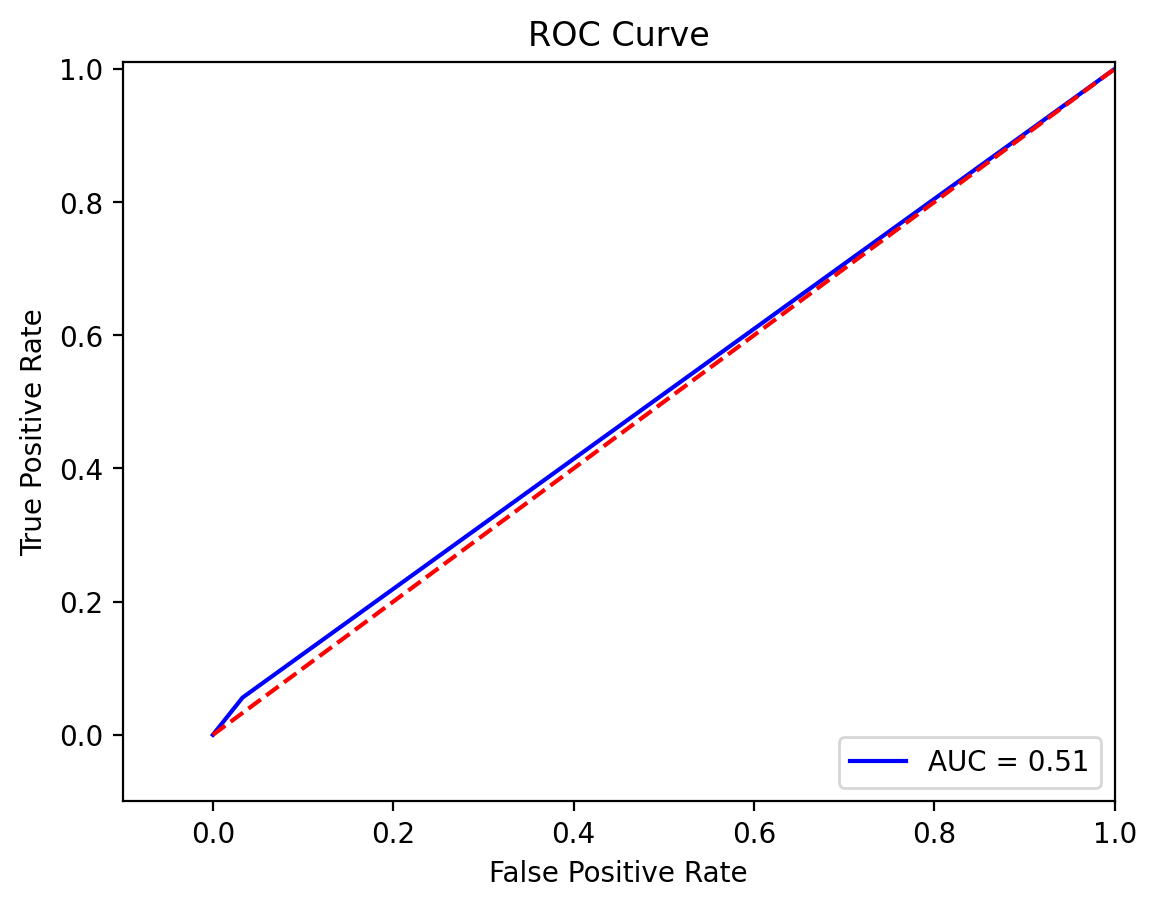

MAE: 0.062498305360483716
MSE: 0.062498305360483716
RMSE: 0.2499966106979927


In [14]:
# Model 1.1: GLM (Tweedie)
from sklearn.linear_model import TweedieRegressor

tweedie_model = TweedieRegressor(power=1, alpha=0.01, link='log') 
# alpha is modified to 0.01 WARNING: 0.5 normally   

tweedie_model = RFE(tweedie_model, n_features_to_select=5)

tweedie_model.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[tweedie_model.support_]

print("Selected Features:")
print(selected_features)

# Predictions
predictions = tweedie_model.predict(X_test)

# min and max values
print('Min:', predictions.min())
print('Max:', predictions.max())

# Count the value above x
print('Count:', np.count_nonzero(predictions > 0.041))

# Force the values above x to 1 and the rest to 0
predictions = np.where(predictions > 0.0492, 1, 0)

# True and False Positives and Negatives
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, predictions))

# Get the rates of True and False Positives and Negatives
tp, fp, fn, tn = confusion_matrix(y_test, predictions).ravel()
print(colored('TN/FP ratio: ' + str(tn/fp), 'red'))

# Print the rates as a percentage
print('True Negatives:', tn / len(y_test) * 100)
print('False Positives:', fp / len(y_test) * 100)
print('False Negatives:', fn / len(y_test) * 100)
print('True Positives:', tp / len(y_test) * 100)

# Create a good metric for the model using the rates puting more weight on the False Negatives
metric = tn / len(y_test) * 100 + tp / len(y_test) * 100 - fp / len(y_test) * 100 - fn / len(y_test) * 100
print('Metric:', metric)

# Roc Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, predictions)

roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.0])
plt.ylim([-0.1, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('MAE:', mean_absolute_error(y_test, predictions))
print('MSE:', mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

[[35684     0]
 [ 1197     0]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     35684
           1       0.00      0.00      0.00      1197

    accuracy                           0.97     36881
   macro avg       0.48      0.50      0.49     36881
weighted avg       0.94      0.97      0.95     36881

Accuracy:  0.9675442639841653


/Users/alexandrecarbo/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexandrecarbo/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexandrecarbo/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


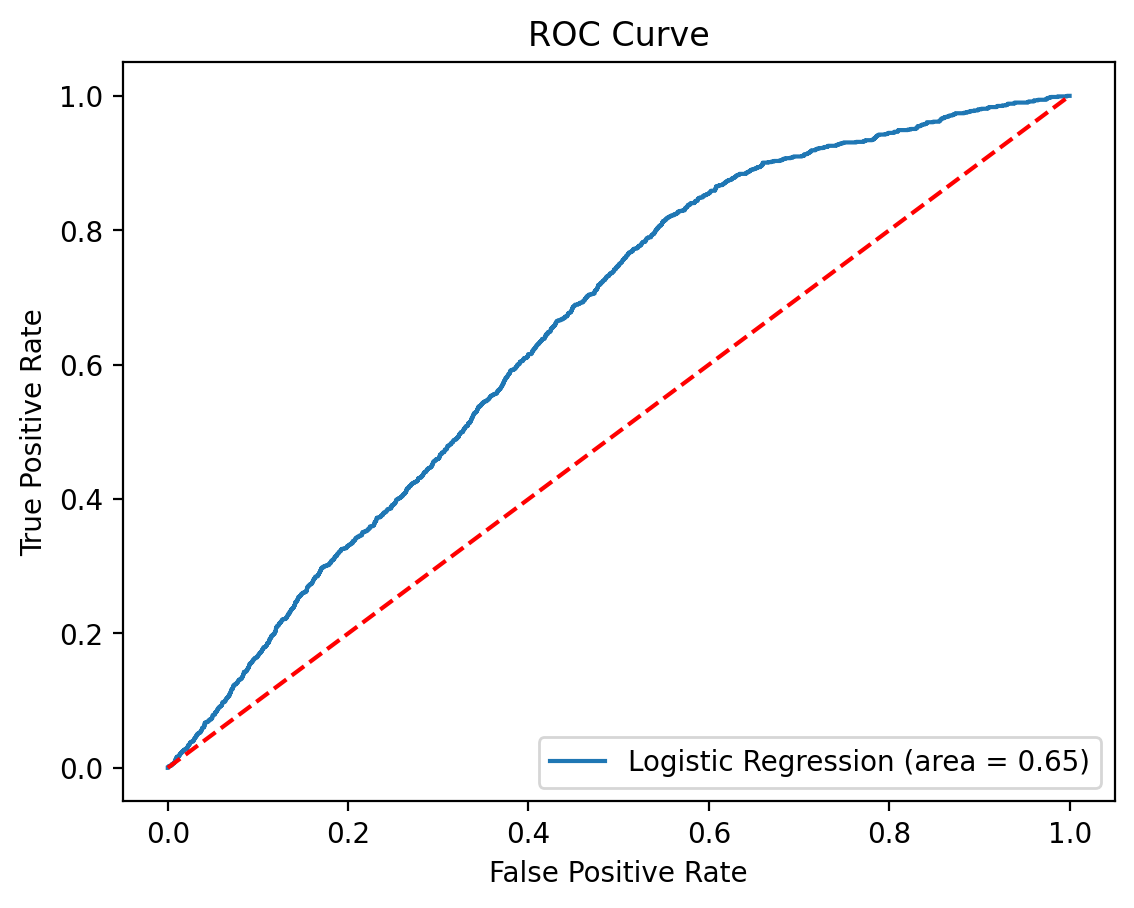

AUC: 0.6527933816531389


In [5]:
# Model 2: Logistic Regression
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()

log_model.fit(X_train, y_train)

# Predictions
predictions = log_model.predict(X_test)

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print("Accuracy: ",log_model.score(X_test, y_test))

# ROC Curve and AUC
from sklearn.metrics import roc_curve, roc_auc_score

y_scores = log_model.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc_score(y_test, y_scores[:,1]))
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Print AUC
print('AUC:', roc_auc_score(y_test, y_scores[:,1]))

[[35684     0]
 [ 1197     0]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     35684
           1       0.00      0.00      0.00      1197

    accuracy                           0.97     36881
   macro avg       0.48      0.50      0.49     36881
weighted avg       0.94      0.97      0.95     36881

Accuracy:  0.968229251923295


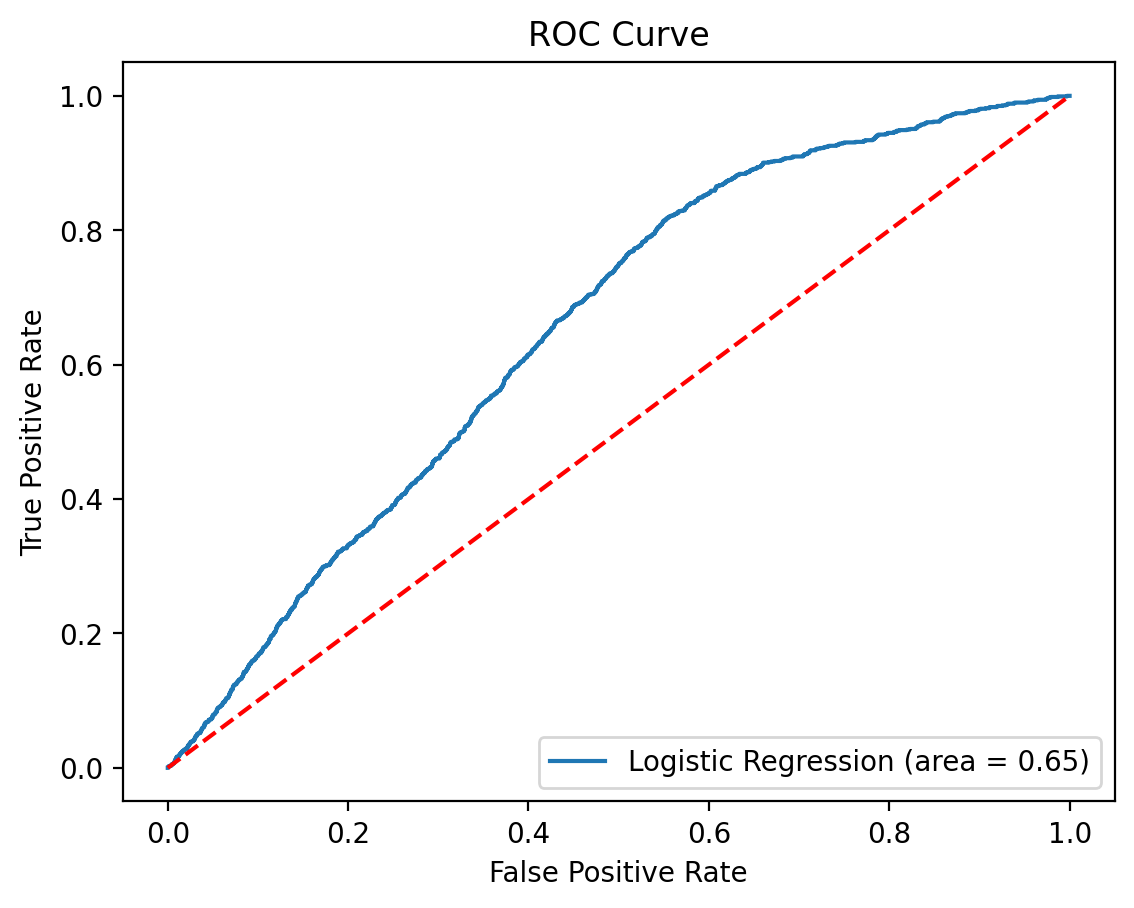

AUC: 0.6528144053291695


In [6]:
# Improve the Logistic Regression Model using GridSearchCV
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

param_grid = {'C': [0.1, 1, 10, 100, 1000], 'penalty': ['l2']}
grid = GridSearchCV(LogisticRegression(), param_grid, refit=True, verbose=0, scoring='accuracy')
grid.fit(X_train, y_train)

# Predictions
grid_predictions = grid.predict(X_test)

# Evaluation
print(confusion_matrix(y_test, grid_predictions))
print(classification_report(y_test, grid_predictions))
# Print best score "the best score achieved during the GridSearchCV is:", grid.best_score_
print("Accuracy: ", grid.best_score_)


# ROC Curve and AUC
y_scores = grid.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc_score(y_test, y_scores[:,1]))
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Print AUC
print('AUC:', roc_auc_score(y_test, y_scores[:,1]))